# Projeto de Previsão da Inflação (IPCA) no Brasil - Modelo Intermediário

Este notebook representa a segunda etapa do projeto de previsão da variação mensal do IPCA. Nesta versão "intermediária", o objetivo é aprimorar o modelo básico de Regressão Linear (que utilizava apenas lags do IPCA) através da inclusão de variáveis macroeconômicas exógenas relevantes: a Taxa Selic e a Taxa de Câmbio (USD/BRL).

**Objetivos Específicos desta Versão:**
* Coletar e tratar os dados históricos do IPCA, da Taxa Selic e da Taxa de Câmbio a partir de 2000.
* Realizar uma análise exploratória das novas séries.
* Integrar as novas variáveis ao conjunto de dados.
* Criar features baseadas em lags para todas as variáveis.
* Treinar um modelo de Regressão Linear com o conjunto de features enriquecido.
* Avaliar o desempenho do novo modelo e compará-lo com a versão básica.

*A motivação é verificar se a adição de informação macroeconômica pode melhorar a capacidade preditiva do modelo simples.*

In [ ]:
!pip install python-bcb

In [ ]:
import pandas as pd
import numpy as np
from bcb import sgs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Coleta e Preparação dos Dados (a partir de 2000)

Nesta seção, faremos a coleta das séries temporais do IPCA, da Taxa Selic (efetiva diária) e da Taxa de Câmbio (PTAX venda). Todas as séries serão obtidas a partir de janeiro de 2010 para garantir alinhamento e contornar possíveis problemas da API com dados mais antigos. Após a coleta, as séries diárias (Selic e Câmbio) serão agregadas para uma frequência mensal.

In [ ]:
# Coleta do IPCA (Série 433)
ipca_dados = sgs.get({'IPCA': 433}, start='2000-01-01')
ipca_dados.index = pd.to_datetime(ipca_dados.index) # Garante DatetimeIndex

ipca_dados.index = ipca_dados.index + pd.offsets.MonthEnd(0)

print("--- IPCA Dados ---")
print(ipca_dados.head())
print("\n")
print(ipca_dados.tail())
ipca_dados.info()

--- IPCA Dados ---
            IPCA
Date            
2000-01-31  0.62
2000-02-29  0.13
2000-03-31  0.22
2000-04-30  0.42
2000-05-31  0.01


            IPCA
Date            
2024-12-31  0.52
2025-01-31  0.16
2025-02-28  1.31
2025-03-31  0.56
2025-04-30  0.43
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2000-01-31 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IPCA    304 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


In [ ]:
# Coleta e Processamento da Selic (Série 11 - Diária Efetiva) - A PARTIR DE 2000
print("\n--- Buscando Taxa Selic Diária Efetiva (código 11) a partir de 2000 ---")
selic_mensal = pd.DataFrame()
try:
    start_date_2000 = pd.to_datetime('2000-01-01')
    end_date_2009 = pd.to_datetime('2009-12-31')
    start_date_2010 = pd.to_datetime('2010-01-01')
    end_date_2019 = pd.to_datetime('2019-12-31')
    start_date_2020 = pd.to_datetime('2020-01-01')

    selic_diaria_p1 = sgs.get({'SELIC_DIARIA_AD': 11}, start=start_date_2000.strftime('%Y-%m-%d'), end=end_date_2009.strftime('%Y-%m-%d'))
    selic_diaria_p2 = sgs.get({'SELIC_DIARIA_AD': 11}, start=start_date_2010.strftime('%Y-%m-%d'), end=end_date_2019.strftime('%Y-%m-%d'))
    selic_diaria_p3 = sgs.get({'SELIC_DIARIA_AD': 11}, start=start_date_2020.strftime('%Y-%m-%d'))

    selic_diaria_raw = pd.concat([selic_diaria_p1, selic_diaria_p2, selic_diaria_p3])
    selic_diaria_raw = selic_diaria_raw[~selic_diaria_raw.index.duplicated(keep='first')]
    selic_diaria_raw.index = pd.to_datetime(selic_diaria_raw.index)

    selic_mensal_temp = selic_diaria_raw.resample('ME').mean()
    selic_mensal_temp.rename(columns={'SELIC_DIARIA_AD': 'SELIC_DIARIA_AVG_MENSAL'}, inplace=True)
    selic_mensal = selic_mensal_temp
    print("\nSelic Diária Média Mensal (% a.d.):")
    selic_mensal.info()
    print(selic_mensal.head())
except Exception as e:
    print(f"Erro ao buscar ou processar Selic Diária Efetiva (11): {e}")


--- Buscando Taxa Selic Diária Efetiva (código 11) a partir de 2000 ---

Selic Diária Média Mensal (% a.d.):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305 entries, 2000-01-31 to 2025-05-31
Freq: ME
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SELIC_DIARIA_AVG_MENSAL  305 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
            SELIC_DIARIA_AVG_MENSAL
Date                               
2000-01-31                 0.068845
2000-02-29                 0.068617
2000-03-31                 0.068541
2000-04-30                 0.067777
2000-05-31                 0.067423


In [ ]:
# Coleta e Processamento do Câmbio (Série 1 - Dólar PTAX Venda) - A PARTIR DE 2000
print("\n--- Buscando Taxa de Câmbio (código 1) a partir de 2000 ---")
cambio_mensal = pd.DataFrame()
try:
    start_date_2000 = pd.to_datetime('2000-01-01')
    end_date_2009 = pd.to_datetime('2009-12-31')
    start_date_2010 = pd.to_datetime('2010-01-01')
    end_date_2019 = pd.to_datetime('2019-12-31')
    start_date_2020 = pd.to_datetime('2020-01-01')

    cambio_diario_p1 = sgs.get({'CAMBIO_USD_VENDA': 1}, start=start_date_2000.strftime('%Y-%m-%d'), end=end_date_2009.strftime('%Y-%m-%d'))
    cambio_diario_p2 = sgs.get({'CAMBIO_USD_VENDA': 1}, start=start_date_2010.strftime('%Y-%m-%d'), end=end_date_2019.strftime('%Y-%m-%d'))
    cambio_diario_p3 = sgs.get({'CAMBIO_USD_VENDA': 1}, start=start_date_2020.strftime('%Y-%m-%d'))

    cambio_diario_raw = pd.concat([cambio_diario_p1, cambio_diario_p2, cambio_diario_p3])
    cambio_diario_raw = cambio_diario_raw[~cambio_diario_raw.index.duplicated(keep='first')]
    cambio_diario_raw.index = pd.to_datetime(cambio_diario_raw.index)

    cambio_mensal_temp = cambio_diario_raw.resample('ME').mean()
    cambio_mensal_temp.rename(columns={'CAMBIO_USD_VENDA': 'CAMBIO_USD_AVG'}, inplace=True)
    cambio_mensal = cambio_mensal_temp
    print("\nCâmbio Médio Mensal:")
    cambio_mensal.info()
    print(cambio_mensal.head())
except Exception as e:
    print(f"Erro ao buscar ou processar Taxa de Câmbio (1): {e}")


--- Buscando Taxa de Câmbio (código 1) a partir de 2000 ---

Câmbio Médio Mensal:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305 entries, 2000-01-31 to 2025-05-31
Freq: ME
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CAMBIO_USD_AVG  305 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
            CAMBIO_USD_AVG
Date                      
2000-01-31        1.803724
2000-02-29        1.775290
2000-03-31        1.742033
2000-04-30        1.768168
2000-05-31        1.827932


### Junção dos DataFrames
Com as três séries temporais (IPCA, Selic e Câmbio) coletadas e agregadas para a frequência mensal, o próximo passo é uni-las em um único DataFrame. Utilizaremos a data (índice) como chave para a junção. A opção `how='inner'` no merge garantirá que apenas os meses para os quais todas as três séries possuem dados sejam mantidos no DataFrame resultante, assegurando o alinhamento temporal.

In [ ]:
# Unindo os DataFrames
df_intermediario = pd.merge(ipca_dados, selic_mensal, left_index=True, right_index=True, how='inner')
df_intermediario = pd.merge(df_intermediario, cambio_mensal, left_index=True, right_index=True, how='inner')

print("\n--- DataFrame Intermediário Combinado ---")
print(df_intermediario.head())
print("\n")
print(df_intermediario.tail())
df_intermediario.info()


--- DataFrame Intermediário Combinado ---
            IPCA  SELIC_DIARIA_AVG_MENSAL  CAMBIO_USD_AVG
Date                                                     
2000-01-31  0.62                 0.068845        1.803724
2000-02-29  0.13                 0.068617        1.775290
2000-03-31  0.22                 0.068541        1.742033
2000-04-30  0.42                 0.067777        1.768168
2000-05-31  0.01                 0.067423        1.827932


            IPCA  SELIC_DIARIA_AVG_MENSAL  CAMBIO_USD_AVG
Date                                                     
2024-12-31  0.52                 0.044158        6.097029
2025-01-31  0.16                 0.045833        6.021773
2025-02-28  1.31                 0.049037        5.765645
2025-03-31  0.56                 0.050508        5.746811
2025-04-30  0.43                 0.052531        5.783675
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2000-01-31 to 2025-04-30
Data columns (total 3 columns):
 #   Column         

O DataFrame `df_intermediario` foi criado com sucesso, contendo agora as séries mensais do IPCA, da média da Selic diária (% a.d.) e da média do Câmbio (USD/BRL), todas alinhadas para o mesmo período (começando em janeiro de 2000 e indo até abril de 2025, resultando em 304 entradas).


## 2. Análise Exploratória dos Dados (EDA) - DataFrame Combinado

Com o DataFrame `df_intermediario` contendo as séries do IPCA, Selic e Câmbio, vamos realizar uma breve análise exploratória para visualizar as séries e suas estatísticas descritivas. Isso nos ajudará a entender melhor as características dos dados que utilizaremos como base para as features do modelo.

In [ ]:
# Estatísticas Descritivas do DataFrame Combinado
print("\n--- Estatísticas Descritivas (df_intermediario) ---")
print(df_intermediario.describe())


--- Estatísticas Descritivas (df_intermediario) ---
             IPCA  SELIC_DIARIA_AVG_MENSAL  CAMBIO_USD_AVG
count  304.000000               304.000000      304.000000
mean     0.502632                 0.045391        3.120580
std      0.395551                 0.017471        1.289728
min     -0.680000                 0.007469        1.563938
25%      0.260000                 0.033628        2.034141
50%      0.450000                 0.044672        2.763106
75%      0.675000                 0.056333        3.887831
max      3.020000                 0.092758        6.097029


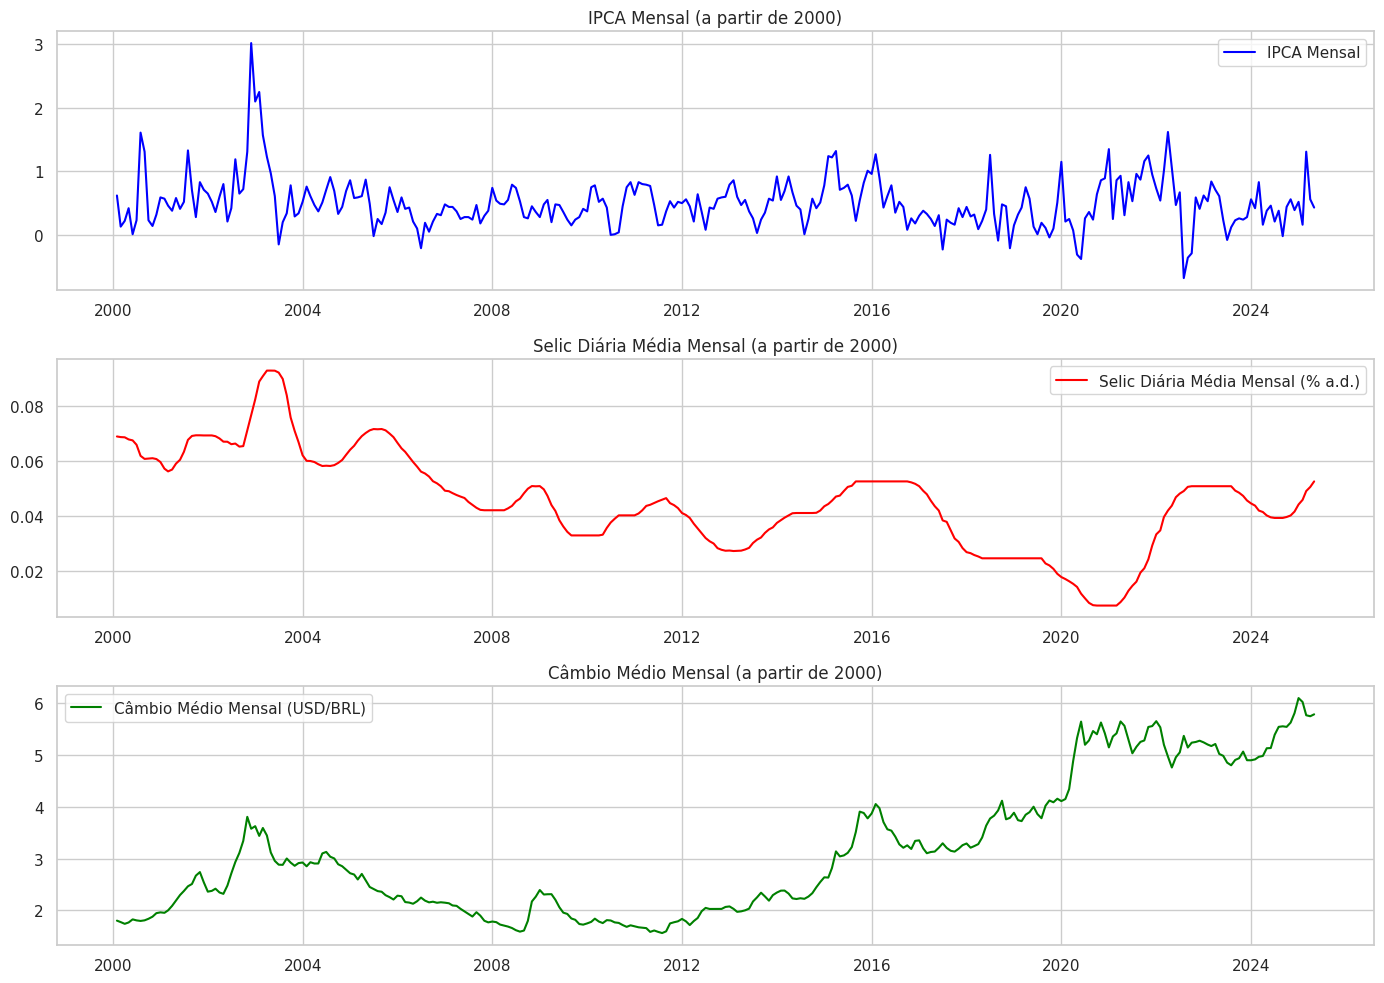

In [ ]:
# Gráficos das séries temporais (IPCA, Selic, Câmbio)
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(df_intermediario.index, df_intermediario['IPCA'], label='IPCA Mensal', color='blue')
plt.title('IPCA Mensal (a partir de 2000)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_intermediario.index, df_intermediario['SELIC_DIARIA_AVG_MENSAL'], label='Selic Diária Média Mensal (% a.d.)', color='red')
plt.title('Selic Diária Média Mensal (a partir de 2000)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_intermediario.index, df_intermediario['CAMBIO_USD_AVG'], label='Câmbio Médio Mensal (USD/BRL)', color='green')
plt.title('Câmbio Médio Mensal (a partir de 2000)')
plt.legend()

plt.tight_layout()
plt.show()

### Análise Visual Detalhada das Séries Temporais (IPCA, Selic e Câmbio - a partir de 2000)

Os gráficos acima exibem a evolução mensal do IPCA, da média da taxa Selic diária (convertida para % a.d.) e da média da taxa de Câmbio (USD/BRL) desde janeiro de 2000 até aproximadamente abril/maio de 2025. Uma análise mais aprofundada, correlacionando com eventos econômicos, revela dinâmicas importantes:

* **IPCA (Inflação Mensal):**
    * **Início dos anos 2000:** A inflação mostra alguma volatilidade, mas o pico mais expressivo ocorre em **2002-2003**. Este período foi marcado por forte **incerteza eleitoral** (eleição de Lula em 2002), que gerou desvalorização cambial e pressões de repasse para os preços. A meta de inflação foi consideravelmente estourada em 2002.
    * **2004-2010:** Após o choque de 2002/2003, observa-se um período de inflação relativamente mais comportada, embora com flutuações. A crise financeira global de **2008** teve um impacto inicial de desvalorização cambial e um repique inflacionário no final daquele ano e início de 2009, mas a recessão global subsequente ajudou a arrefecer as pressões.
    * **2011-2014:** A inflação começa a mostrar uma tendência de alta mais persistente, frequentemente rondando o teto da meta. Este período foi caracterizado por uma política econômica de **estímulos à demanda** e controle de preços administrados, que mascararam parte da pressão inflacionária subjacente.
    * **2015-2016:** Um **forte pico inflacionário** ocorre, ultrapassando os 10% ao ano. Este período coincide com uma **severa crise econômica e política no Brasil**, deterioração das contas fiscais, forte desvalorização cambial e realinhamento de preços administrados (como energia elétrica e combustíveis) que estavam represados.
    * **2017-2019:** Após o choque de 2015/2016, a inflação recua significativamente, atingindo níveis baixos, auxiliada pela recessão que reduziu a demanda e pela mudança na política econômica. A **greve dos caminhoneiros em maio de 2018** causou um repique temporário no IPCA.
    * **2020-2022:** Um novo **ciclo de alta expressiva da inflação** se inicia. Este foi influenciado por múltiplos fatores:
        * **Pandemia de COVID-19 (a partir de 2020):** Desorganização das cadeias produtivas globais, aumento dos custos de frete.
        * **Políticas de estímulo à renda:** Aumento da demanda em certos setores.
        * **Crise hídrica (2021):** Encarecimento da energia elétrica (acionamento de termelétricas mais caras).
        * **Alta das commodities globais:** Especialmente alimentos e petróleo, intensificada pela guerra na Ucrânia a partir de fevereiro de 2022.
        * **Forte desvalorização cambial** no início da pandemia.
    * **Meados de 2022-2023:** Observa-se uma **desaceleração da inflação**, incluindo alguns meses de deflação em meados de 2022 (influenciada por cortes de impostos sobre combustíveis e energia). A política monetária mais apertada começa a surtir efeito.
    * **2024-Início de 2025:** A inflação parece ter se estabilizado em um patamar mais baixo que os picos de 2022, mas ainda com alguma volatilidade e desafios para convergir para o centro da meta.

* **Selic (Média Diária Mensal, % a.d.):**
    * A Selic (gráfico do meio) é o principal instrumento do Banco Central para controlar a inflação.
    * **Resposta ao choque de 2002/2003:** A Selic foi elevada agressivamente, atingindo patamares superiores a 0.09% a.d. (equivalente a mais de 25% a.a.) em meados de 2003 para combater a alta inflacionária.
    * **2004-2008:** Ciclo de queda gradual, interrompido por uma elevação em 2008 devido ao repique inflacionário da crise global.
    * **2009-2012:** Novo ciclo de queda, levando a Selic a mínimas históricas (para a época) em 2012, buscando estimular a economia.
    * **2013-2015/2016:** Diante da reaceleração inflacionária, o Banco Central promove um novo ciclo de alta da Selic, que atinge novamente níveis elevados.
    * **2016-2020:** Com a queda da inflação após a crise, a Selic entra em um longo ciclo de cortes, atingindo a mínima histórica de 2% a.a. (aproximadamente 0.0075% a.d. na média mensal) em 2020, como resposta também aos impactos iniciais da pandemia.
    * **2021-2022:** Para combater o forte surto inflacionário, o Banco Central implementa um dos mais rápidos e intensos ciclos de alta da Selic, elevando a taxa de 2% a.a. para mais de 13% a.a.
    * **Meados de 2023 em diante:** Com a inflação arrefecendo, a Selic inicia um novo ciclo de cortes graduais.

* **Câmbio (Médio Mensal USD/BRL):**
    * A taxa de câmbio (gráfico inferior) é uma variável crucial para a inflação brasileira devido ao seu impacto nos preços de bens comercializáveis (importados e exportáveis).
    * **2001-2002:** Forte desvalorização do Real (dólar se aproximando de R$4,00) devido à crise de confiança associada à transição de governo e aversão global ao risco.
    * **2003-2008 (até meados):** Período de apreciação cambial significativa, com o dólar atingindo valores próximos a R$1,60, beneficiado pelo boom de commodities e fluxos de capital.
    * **Crise de 2008:** Desvalorização abrupta com a crise global, mas com recuperação parcial nos anos seguintes.
    * **2012-2015:** Novo ciclo de desvalorização, intensificado em 2014-2015 pela crise interna e fim do ciclo de alta das commodities, com o dólar novamente superando R$4,00.
    * **2016-2019:** O câmbio permanece em um patamar mais desvalorizado (entre R$3,00 e R$4,00), com volatilidade.
    * **A partir de 2020:** A pandemia e incertezas fiscais internas levam o dólar a um novo patamar, ultrapassando R$5,00 e chegando a R$5,50-R$6,00 em alguns momentos, mantendo-se elevado desde então.

* **Relações Visuais e Dinâmicas entre as Séries:**
    * **Câmbio e IPCA:** Períodos de forte desvalorização cambial (ex: 2002, 2015, 2020-2021) são frequentemente seguidos por picos inflacionários, evidenciando o efeito de repasse cambial.
    * **Selic e IPCA:** A Selic é tipicamente elevada em resposta a aumentos da inflação (ou de suas expectativas) e/ou a choques cambiais. O efeito da alta de juros sobre a inflação ocorre com defasagem, geralmente de seis a nove meses ou mais, atuando via desaceleração da demanda e ancoragem das expectativas. Os ciclos de queda da Selic também estão associados a períodos onde a inflação está sob controle ou em queda.
    * **Selic e Câmbio:** A relação não é sempre direta, mas taxas de juros internas (Selic) muito mais altas que as internacionais podem atrair capital e ajudar a apreciar o Real (ou conter desvalorizações), enquanto juros internos baixos podem estimular saídas de capital e pressionar o câmbio. No entanto, fatores de risco fiscal e político muitas vezes se sobrepõem a essa dinâmica.

Esta análise visual detalhada, contextualizada com os eventos econômicos, reforça a expectativa de que os lags da Selic e do Câmbio possam agregar valor explicativo ao modelo de previsão do IPCA, capturando parte da complexa dinâmica macroeconômica brasileira.

### Engenharia de Features: Criando Lags para IPCA, Selic e Câmbio

Agora que já carregamos as séries, unificamos tudo no dataframe df_intermediario e demos uma olhada nos gráficos, o próximo passo é construir as variáveis (ou features) que o nosso modelo vai usar.

Vamos manter a estratégia de usar os valores passados (lags) do próprio IPCA, considerando os três últimos períodos. Além disso, vamos adicionar também lags para as novas informações que incluímos: dois lags para a média mensal da Selic diária e outros dois para a média mensal do Câmbio.

A ideia de incluir esses lags para a Selic e o Câmbio é que o efeito dessas variáveis macroeconômicas na inflação geralmente não acontece de uma hora para outra. Costuma haver um certo atraso, uma defasagem, e é justamente essa dinâmica que queremos que o modelo consiga capturar.



In [ ]:
# Lags do IPCA
df_intermediario['IPCA_lag1'] = df_intermediario['IPCA'].shift(1)
df_intermediario['IPCA_lag2'] = df_intermediario['IPCA'].shift(2)
df_intermediario['IPCA_lag3'] = df_intermediario['IPCA'].shift(3)

# Lags da Selic
df_intermediario['SELIC_lag1'] = df_intermediario['SELIC_DIARIA_AVG_MENSAL'].shift(1)
df_intermediario['SELIC_lag2'] = df_intermediario['SELIC_DIARIA_AVG_MENSAL'].shift(2)

# Lags do Câmbio
df_intermediario['CAMBIO_lag1'] = df_intermediario['CAMBIO_USD_AVG'].shift(1)
df_intermediario['CAMBIO_lag2'] = df_intermediario['CAMBIO_USD_AVG'].shift(2)

print("\n--- DataFrame com todos os lags (primeiras 7 linhas para ver os NaNs) ---")
print(df_intermediario.head(7))

# Removendo NaNs (o maior lag é de 3 meses para o IPCA)
df_intermediario.dropna(inplace=True)

print("\n--- DataFrame após remover NaNs (primeiras linhas) ---")
print(df_intermediario.head())
df_intermediario.info()


--- DataFrame com todos os lags (primeiras 7 linhas para ver os NaNs) ---
            IPCA  SELIC_DIARIA_AVG_MENSAL  CAMBIO_USD_AVG  IPCA_lag1  \
Date                                                                   
2000-01-31  0.62                 0.068845        1.803724        NaN   
2000-02-29  0.13                 0.068617        1.775290       0.62   
2000-03-31  0.22                 0.068541        1.742033       0.13   
2000-04-30  0.42                 0.067777        1.768168       0.22   
2000-05-31  0.01                 0.067423        1.827932       0.42   
2000-06-30  0.23                 0.065838        1.808329       0.01   
2000-07-31  1.61                 0.061807        1.797824       0.23   

            IPCA_lag2  IPCA_lag3  SELIC_lag1  SELIC_lag2  CAMBIO_lag1  \
Date                                                                    
2000-01-31        NaN        NaN         NaN         NaN          NaN   
2000-02-29        NaN        NaN    0.068845         NaN 

A criação dos lags introduziu valores `NaN` (ausentes) nas primeiras linhas do `df_intermediario`, pois não há dados suficientes para calcular todos os lags para essas observações iniciais. Como o maior lag utilizado foi de 3 meses (para o IPCA), as 3 primeiras linhas do DataFrame após a criação dos lags continham `NaN`s.

Essas linhas foram removidas com o método `.dropna()`. O `.info()` resultante mostra que o DataFrame agora possui 301 entradas e está pronto para a separação em features e variável alvo.


### Definindo Features (X_int) e Variável Alvo (y_int) para o Modelo Intermediário

Agora, separamos o DataFrame processado em:
* `X_int`: DataFrame contendo todas as nossas features (lags do IPCA, lags da Selic e lags do Câmbio).
* `y_int`: Série contendo a nossa variável alvo (o valor atual do IPCA que queremos prever).

In [ ]:
# Features (X_int) e Variável Alvo (y_int)
features_intermediarias = [
    'IPCA_lag1', 'IPCA_lag2', 'IPCA_lag3',
    'SELIC_lag1', 'SELIC_lag2',
    'CAMBIO_lag1', 'CAMBIO_lag2'
]
X_int = df_intermediario[features_intermediarias]
y_int = df_intermediario['IPCA']

print("\n--- Features X_int (primeiras linhas) ---")
print(X_int.head())
print("\n--- Alvo y_int (primeiras linhas) ---")
print(y_int.head())


--- Features X_int (primeiras linhas) ---
            IPCA_lag1  IPCA_lag2  IPCA_lag3  SELIC_lag1  SELIC_lag2  \
Date                                                                  
2000-04-30       0.22       0.13       0.62    0.068541    0.068617   
2000-05-31       0.42       0.22       0.13    0.067777    0.068541   
2000-06-30       0.01       0.42       0.22    0.067423    0.067777   
2000-07-31       0.23       0.01       0.42    0.065838    0.067423   
2000-08-31       1.61       0.23       0.01    0.061807    0.065838   

            CAMBIO_lag1  CAMBIO_lag2  
Date                                  
2000-04-30     1.742033     1.775290  
2000-05-31     1.768168     1.742033  
2000-06-30     1.827932     1.768168  
2000-07-31     1.808329     1.827932  
2000-08-31     1.797824     1.808329  

--- Alvo y_int (primeiras linhas) ---
Date
2000-04-30    0.42
2000-05-31    0.01
2000-06-30    0.23
2000-07-31    1.61
2000-08-31    1.31
Name: IPCA, dtype: float64


As features (`X_int`) e a variável alvo (`y_int`) foram definidas. Cada linha em `X_int` contém os valores defasados do IPCA, Selic e Câmbio que serão usados para tentar prever o valor do IPCA correspondente na mesma linha de `y_int`.

## Treinamento do Modelo (Regressão Linear com Novas Features)

Com o novo conjunto de features (`X_int`) e a variável alvo (`y_int`) definidos, procederemos com a divisão dos dados em treino e teste e o treinamento do modelo de Regressão Linear.

### Divisão em Dados de Treino e Teste
Manteremos a estratégia de usar os últimos **24 meses** para teste, para permitir uma comparação mais direta com o desempenho do modelo básico.

In [ ]:
# Divisão em Dados de Treino e Teste
n_teste_int = 24 # Mantendo 24 meses para teste

X_int_treino = X_int[:-n_teste_int]
y_int_treino = y_int[:-n_teste_int]
X_int_teste = X_int[-n_teste_int:]
y_int_teste = y_int[-n_teste_int:]

print("\n--- Dimensões dos Conjuntos ---")
print("X_int_treino:", X_int_treino.shape)
print("y_int_treino:", y_int_treino.shape)
print("X_int_teste:", X_int_teste.shape)
print("y_int_teste:", y_int_teste.shape)

# Opcional: Olhar as últimas linhas do treino e primeiras do teste para confirmar a divisão
print("\nÚltimas 5 linhas de X_int_treino (índice):")
print(X_int_treino.tail().index.strftime('%Y-%m-%d'))
print("\nPrimeiras 5 linhas de X_int_teste (índice):")
print(X_int_teste.head().index.strftime('%Y-%m-%d'))


--- Dimensões dos Conjuntos ---
X_int_treino: (277, 7)
y_int_treino: (277,)
X_int_teste: (24, 7)
y_int_teste: (24,)

Últimas 5 linhas de X_int_treino (índice):
Index(['2022-12-31', '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30'], dtype='object', name='Date')

Primeiras 5 linhas de X_int_teste (índice):
Index(['2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30'], dtype='object', name='Date')


Os dados foram divididos. O conjunto de treino (`X_int_treino`, `y_int_treino`) possui 277 observações, e o conjunto de teste (`X_int_teste`, `y_int_teste`) possui as 24 observações mais recentes.


### Treinando o Modelo de Regressão Linear Intermediário
O modelo de Regressão Linear será treinado com o conjunto de treino, agora contendo os lags do IPCA, da Selic e do Câmbio.

In [ ]:
# Treinando o Modelo de Regressão Linear
modelo_linear_intermediario = LinearRegression()
modelo_linear_intermediario.fit(X_int_treino, y_int_treino)

print("\n--- Modelo Linear Intermediário Treinado ---")
print(f"Intercepto: {modelo_linear_intermediario.intercept_:.4f}")
print("Coeficientes:")
for feature, coef in zip(X_int_treino.columns, modelo_linear_intermediario.coef_):
    print(f"{feature}: {coef:.4f}")


--- Modelo Linear Intermediário Treinado ---
Intercepto: 0.1025
Coeficientes:
IPCA_lag1: 0.6047
IPCA_lag2: -0.0879
IPCA_lag3: -0.0093
SELIC_lag1: 40.9917
SELIC_lag2: -38.9817
CAMBIO_lag1: 0.3737
CAMBIO_lag2: -0.3536


### Análise dos Coeficientes (Modelo Intermediário)

O modelo de Regressão Linear intermediário, treinado com dados desde 2000 e incluindo lags do IPCA, Selic e Câmbio, apresentou os seguintes parâmetros:

* **Intercepto (β₀):** `0.1025`
* **Coeficientes (β) para os lags:**
    * IPCA_lag1: `0.6047`
    * IPCA_lag2: `-0.0879`
    * IPCA_lag3: `-0.0093`
    * SELIC_lag1: `40.9917`
    * SELIC_lag2: `-38.9817`
    * CAMBIO_lag1: `0.3737`
    * CAMBIO_lag2: `-0.3536`

*Minha análise dos coeficientes:*

* **Lags do IPCA:** O `IPCA_lag1` (inflação do mês anterior) continua sendo a feature com o maior impacto positivo e mais intuitivo (`0.6047`). Isso sugere uma forte persistência inflacionária, onde a inflação do mês passado é um bom preditor da inflação atual. Os coeficientes para `IPCA_lag2` e `IPCA_lag3` são consideravelmente menores e até negativos, indicando uma influência linear direta menos significativa desses lags mais distantes, uma vez que o primeiro lag já foi considerado.

* **Lags da Selic:**
    * `SELIC_lag1` tem um coeficiente positivo e muito alto (`40.9917`).
    * `SELIC_lag2` tem um coeficiente negativo e igualmente alto em magnitude (`-38.9817`).
    * **Observação sobre a escala:** É fundamental notar que a variável `SELIC_DIARIA_AVG_MENSAL` (média mensal da Selic diária em % a.d.) possui valores muito pequenos (ex: média de 0.0381% a.d. no `df_intermediario.describe()`). Na regressão linear, quando uma feature tem uma escala muito pequena, seu coeficiente pode se tornar artificialmente grande para compensar essa escala na equação final. Portanto, a magnitude de "40" não implica diretamente um impacto de 40 pontos percentuais na inflação para uma variação de 1 unidade na Selic (que seria variar de 0.038% a.d. para 1.038% a.d. – um aumento irrealista na taxa diária).
    * Os sinais opostos e magnitudes semelhantes para `SELIC_lag1` e `SELIC_lag2` são interessantes. Isso pode sugerir que o modelo está tentando capturar o *efeito da variação* da Selic entre t-2 e t-1, ou pode ser um indício de multicolinearidade entre os lags da Selic. Economicamente, espera-se que um aumento na Selic (aperto monetário) leve a uma *redução* da inflação com alguma defasagem, o que sugeriria coeficientes negativos para lags relevantes. A interpretação aqui é complexa e pode indicar que a relação linear simples não está capturando bem a dinâmica da política monetária ou que a escala da variável está influenciando a magnitude dos coeficientes.

* **Lags do Câmbio:**
    * `CAMBIO_lag1` tem um coeficiente positivo (`0.3737`).
    * `CAMBIO_lag2` tem um coeficiente negativo (`-0.3536`).
    * O coeficiente positivo para `CAMBIO_lag1` está alinhado com a intuição econômica: uma desvalorização cambial (aumento do valor do dólar) no mês anterior tende a pressionar a inflação (efeito de repasse cambial). O coeficiente negativo para `CAMBIO_lag2` pode indicar dinâmicas mais complexas ou interações que o modelo linear simples não detalha. A magnitude desses coeficientes é mais moderada em comparação com os da Selic.

*No geral, o `IPCA_lag1` permanece como um preditor chave. Os coeficientes das novas variáveis (Selic e Câmbio) indicam que o modelo encontrou relações lineares, mas sua interpretação econômica direta, especialmente para a Selic, requer cautela devido à escala da variável e à complexidade das relações macroeconômicas. A magnitude dos coeficientes da Selic é um ponto que mereceria investigação adicional, talvez com a padronização das variáveis antes da modelagem para melhor comparabilidade dos coeficientes.*

In [ ]:
# Previsões e Calculando Métricas
previsoes_linear_int = modelo_linear_intermediario.predict(X_int_teste)

mae_linear_int = mean_absolute_error(y_int_teste, previsoes_linear_int)
mse_linear_int = mean_squared_error(y_int_teste, previsoes_linear_int)
rmse_linear_int = np.sqrt(mse_linear_int)

print("\n--- Métricas de Erro (Modelo Intermediário) ---")
print(f"MAE: {mae_linear_int:.4f}")
# print(f"MSE: {mse_linear_int:.4f}") # MSE é menos interpretável, pode omitir o print
print(f"RMSE: {rmse_linear_int:.4f}")

# Para comparação (valores do seu notebook básico)
mae_linear_basico = 0.2404
rmse_linear_basico = 0.3347
print(f"\nComparativo com Modelo Básico:")
print(f"MAE Básico: {mae_linear_basico:.4f} -> MAE Intermediário: {mae_linear_int:.4f}")
print(f"RMSE Básico: {rmse_linear_basico:.4f} -> RMSE Intermediário: {rmse_linear_int:.4f}")


--- Métricas de Erro (Modelo Intermediário) ---
MAE: 0.2739
RMSE: 0.3534

Comparativo com Modelo Básico:
MAE Básico: 0.2404 -> MAE Intermediário: 0.2739
RMSE Básico: 0.3347 -> RMSE Intermediário: 0.3534


### Análise das Métricas de Erro (Modelo Intermediário)

Os resultados das métricas de erro para o modelo intermediário no conjunto de teste (últimos 24 meses da série, que agora começa em 2000) foram:
* **MAE (Erro Absoluto Médio):** `0.2739` p.p.
* **RMSE (Raiz do Erro Quadrático Médio):** `0.3534` p.p.

*Minha análise e comparação com o Modelo Básico (que usava apenas lags do IPCA e dados desde 2000):*
* O MAE do modelo intermediário (`0.2739`) foi **superior** ao MAE do modelo básico (`0.2404`). Isso indica que, em média, os erros absolutos das previsões aumentaram com a inclusão das novas features (Selic e Câmbio) neste modelo linear.
* Similarmente, o RMSE do modelo intermediário (`0.3534`) também foi **maior** que o RMSE do modelo básico (`0.3347`).

*Considerações sobre o resultado:*
* A piora no desempenho sugere que a forma como as novas features (lags da Selic e do Câmbio) foram incorporadas ao modelo linear simples pode não ter sido ótima ou que a relação delas com o IPCA, neste modelo, não é suficientemente linear e benéfica para melhorar as previsões no período de teste.
* **Possíveis razões para a piora:**
    * **Relações Não-Lineares:** A influência da Selic e do Câmbio sobre a inflação é complexa e pode ser não-linear. Um modelo de Regressão Linear pode não capturar adequadamente essas nuances.
    * **Multicolinearidade:** As novas features podem ter correlação com os lags do IPCA ou entre si, o que pode tornar os coeficientes do modelo linear menos estáveis e as previsões menos precisas.
    * **Escala das Variáveis:** A Selic (% a.d.) tem uma escala muito diferente das outras variáveis, o que, embora a regressão linear possa lidar, pode ter influenciado a estimativa dos coeficientes e a sensibilidade do modelo.
    * **Defasagens (Lags):** O número de lags escolhido para Selic e Câmbio (1 e 2 meses) pode não ser o mais apropriado para capturar o impacto dessas variáveis na inflação.
* Este resultado é muito instrutivo, pois nem sempre adicionar mais variáveis a um modelo resulta em melhor desempenho, especialmente se o modelo for simples ou se as novas variáveis introduzirem mais ruído do que sinal útil para aquele algoritmo específico.

Apesar da piora nas métricas, a inclusão dessas variáveis é economicamente relevante, e este resultado nos incentiva a explorar modelos mais sofisticados que possam capturar melhor essas relações complexas.

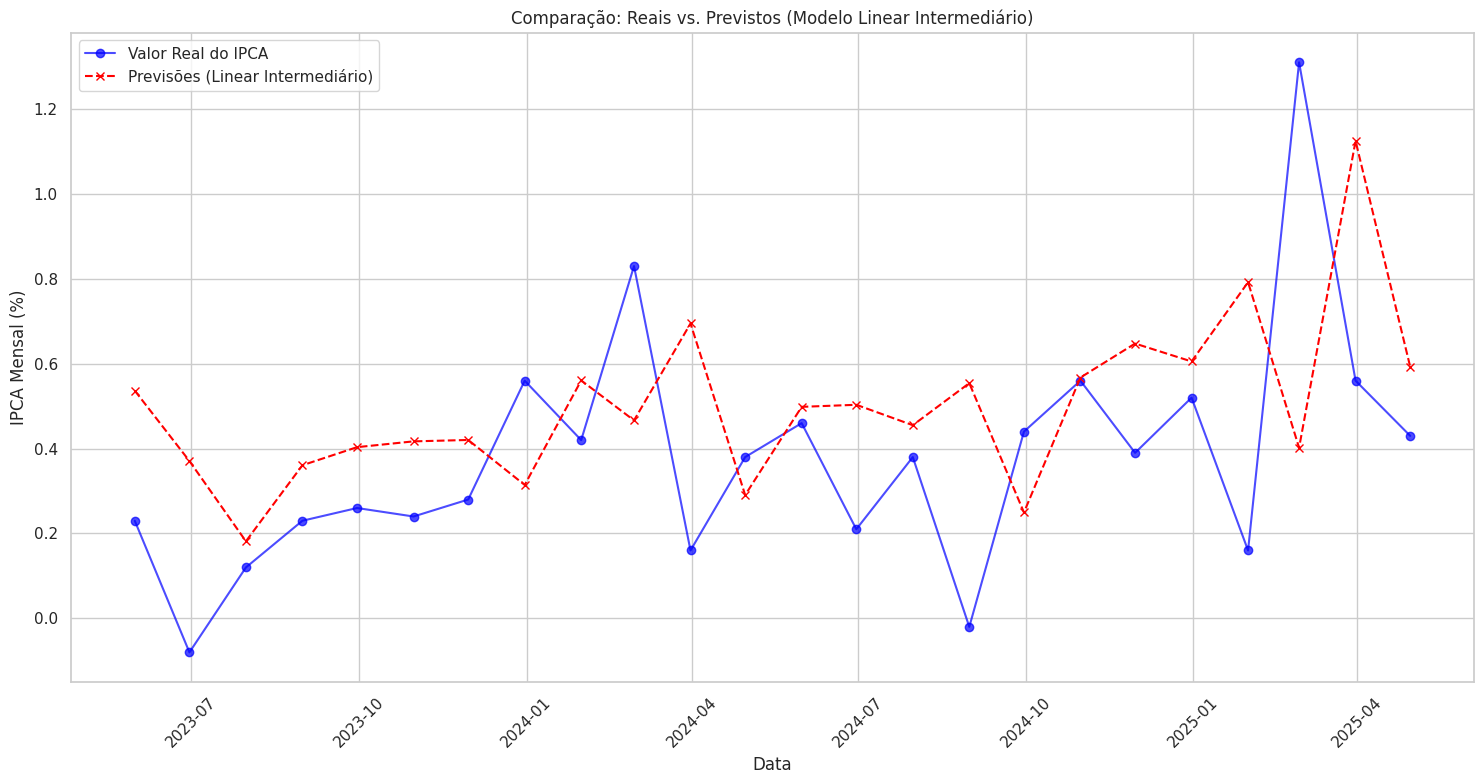

In [ ]:
# Gráfico Comparativo (Reais vs. Previstos - Modelo Intermediário)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.plot(y_int_teste.index, y_int_teste.values, label='Valor Real do IPCA', color='blue', marker='o', alpha=0.7)
plt.plot(y_int_teste.index, previsoes_linear_int, label='Previsões (Linear Intermediário)',color='red', marker='x', linestyle='--')
plt.title('Comparação: Reais vs. Previstos (Modelo Linear Intermediário)')
plt.xlabel('Data')
plt.ylabel('IPCA Mensal (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualização: Reais vs. Previstos (Modelo Linear Intermediário)

O gráfico acima compara visualmente os valores reais do IPCA (linha azul com marcadores 'o') com as previsões geradas pelo modelo linear intermediário (linha laranja tracejada com marcadores 'x') para o conjunto de teste (período de aproximadamente 2023-07 a 2025-04).

*Observações Detalhadas:*

* **Acompanhamento da Tendência:** O modelo intermediário tenta seguir a direção geral das flutuações do IPCA real, mas com dificuldades notáveis em capturar a amplitude e os pontos de virada com precisão.
    * No segundo semestre de 2023, enquanto o IPCA real flutuou entre -0.08% e 0.28%, as previsões do modelo foram consistentemente mais altas, variando entre 0.32% e 0.54%.
    * O modelo não antecipou o pico de 0.83% em março de 2024, prevendo um valor bem inferior (aproximadamente 0.47%).
    * Em abril de 2024, quando o IPCA real caiu para 0.16%, o modelo previu uma alta para cerca de 0.7%.
    * A deflação observada em setembro de 2024 (-0.01%) não foi capturada pelo modelo, que previu uma inflação de cerca de 0.55%.
    * O forte pico inflacionário de 1.31% em março de 2025 foi significativamente subestimado, com uma previsão em torno de 0.4%.
    * Em abril de 2025, o modelo previu 1.12%, enquanto o valor real foi de 0.43%.

* **Magnitude dos Erros:** Fica evidente que o modelo linear, mesmo com as features adicionais de Selic e Câmbio, tem uma tendência a "suavizar" as previsões, não conseguindo reproduzir os valores extremos (tanto picos quanto vales mais acentuados).

* **Comparativo com o Modelo Básico (Qualitativo):** Considerando que as métricas MAE (0.2739) e RMSE (0.3534) do modelo intermediário foram ligeiramente piores que as do modelo básico (MAE: 0.2404, RMSE: 0.3347, ambos usando dados desde 2000), este gráfico corrobora a conclusão de que a simples adição linear dessas features não resultou em uma melhora visual clara na precisão das previsões para este período de teste.

* **Limitações do Modelo:** A complexidade da inflação, influenciada por múltiplos fatores e relações muitas vezes não-lineares, excede a capacidade de um modelo linear simples como o atual.

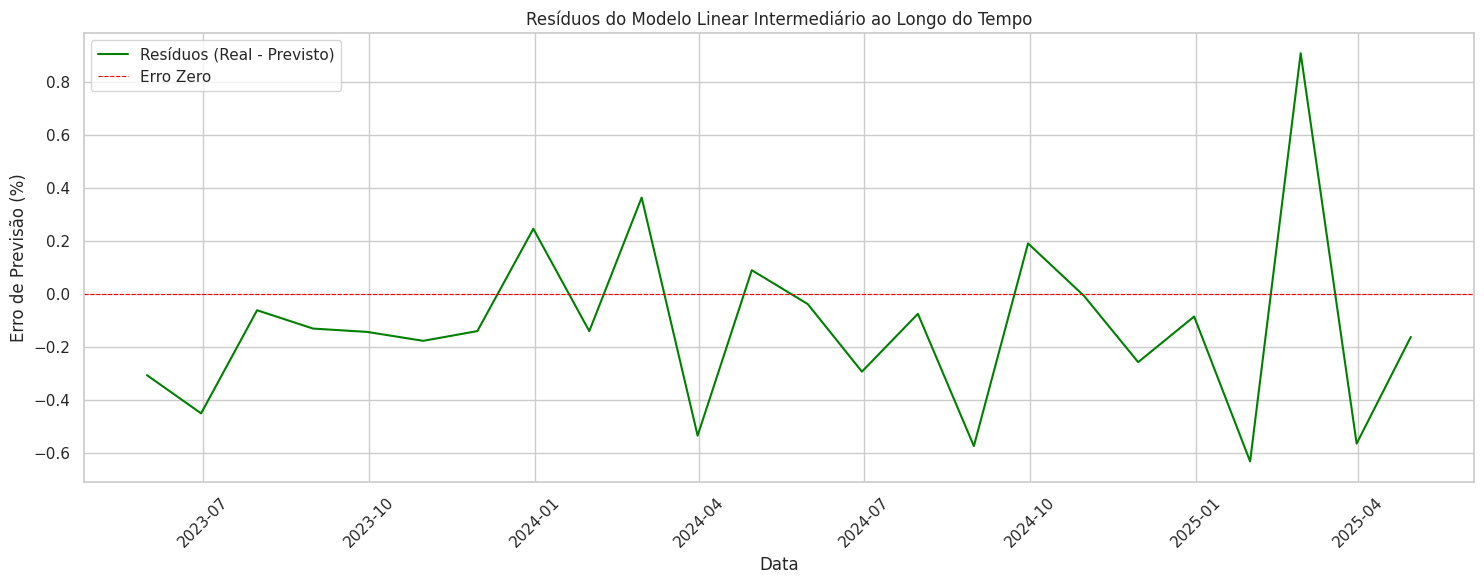

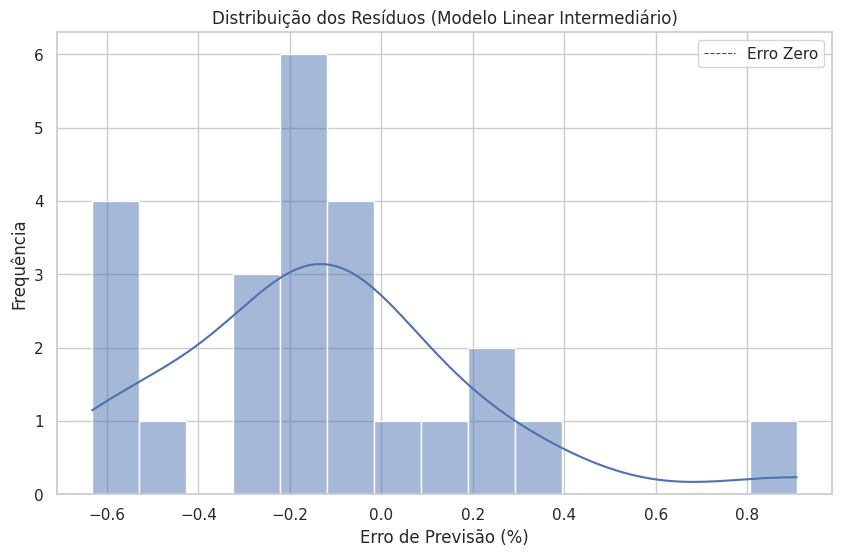

In [ ]:
# Análise de Resíduos (Modelo Intermediário)
residuos_linear_int = y_int_teste.values - previsoes_linear_int

plt.figure(figsize=(15, 6))
plt.plot(y_int_teste.index, residuos_linear_int, label='Resíduos (Real - Previsto)', color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Erro Zero')
plt.title('Resíduos do Modelo Linear Intermediário ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Erro de Previsão (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuos_linear_int, kde=True, bins=15)
plt.title('Distribuição dos Resíduos (Modelo Linear Intermediário)')
plt.xlabel('Erro de Previsão (%)')
plt.ylabel('Frequência')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Erro Zero')
plt.legend()
plt.show()

### Análise dos Resíduos (Modelo Intermediário)

Os gráficos de resíduos (diferença entre os valores reais e os previstos) do modelo linear intermediário ao longo do tempo e sua distribuição de frequência (histograma) fornecem mais insights sobre o desempenho do modelo.

*Observações Detalhadas:*

* **Resíduos ao Longo do Tempo (Primeiro Gráfico):**
    * Os erros de previsão (resíduos) flutuam em torno da linha zero.
    * De julho de 2023 a janeiro de 2024, os resíduos são consistentemente negativos (entre -0.2% e -0.45% aproximadamente), indicando que o modelo **superestimou** a inflação nesse período.
    * Ocorrem **erros positivos grandes** (modelo subestimou a inflação) em março de 2024 (resíduo de aprox. +0.36%) e, de forma muito expressiva, em março de 2025 (resíduo de aprox. +0.9%, o maior erro no período).
    * Observam-se também **erros negativos grandes** (modelo superestimou a inflação) em abril de 2024 (aprox. -0.51%), setembro de 2024 (aprox. -0.56%) e abril de 2025 (aprox. -0.69%).
    * A ausência de uma tendência clara ou padrão cíclico forte e persistente nos resíduos é um ponto relativamente positivo, mas os "clusters" de erros (como a superestimação em 2023) e os picos de erro indicam que o modelo não está capturando toda a dinâmica da série.

* **Histograma dos Resíduos (Segundo Gráfico):**
    * A distribuição dos resíduos está visualmente centrada próxima de zero, com a maior frequência de erros (6 ocorrências) caindo na faixa de -0.2% a -0.1%.
    * A forma da distribuição tem um pico principal e não é perfeitamente simétrica, apresentando **caudas mais evidentes** do que uma distribuição normal ideal. A cauda positiva é influenciada pelo grande erro de +0.9% (março de 2025), e a cauda negativa pelos erros de superestimação (ex: -0.69% em abril de 2025).
    * Isso significa que, embora muitos erros sejam pequenos, o modelo também cometeu alguns erros de magnitude considerável, o que impacta o valor do RMSE.

*Conclusão da Análise de Resíduos:*
Os resíduos não apontam para problemas estruturais críticos no modelo (como uma forte autocorrelação que seria visível no gráfico temporal), mas a presença de erros de maior magnitude e alguns períodos de vieses (superestimação em 2023) são consistentes com as métricas de erro (MAE: 0.2739, RMSE: 0.3534) que indicaram uma performance um pouco inferior à do modelo básico.